Bank Marketing Campaign

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import display


In [59]:
# connect to postgres database 
# select all data

import psycopg2
import pandas as pd
from config import config

import warnings
warnings.filterwarnings('ignore')

def connect():
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # read connection parameters
        params = config()

        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params)
		
        # create a cursor
        cur = conn.cursor()
        
	# execute a statement
        print('PostgreSQL database version:')
        cur.execute('SELECT version()')

        # display the PostgreSQL database server version
        db_version = cur.fetchone()
        print(db_version)
       
    # select all 
        df = pd.read_sql('SELECT * FROM customer',conn)
        # print(df.head())
        return df
        
	# close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')
    

if __name__ == '__main__':
    connect()
    
    

df = connect()



Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 14.2, compiled by Visual C++ build 1914, 64-bit',)
Database connection closed.
Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 14.2, compiled by Visual C++ build 1914, 64-bit',)
Database connection closed.


In [60]:
# overview   

display(df.shape)
display(df.head())

(45211, 17)

,age,job,marital_status,education,default_status,balance,housing,loan,contact,day_of_month,month_name,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


The data consists of over 45,000 records and 17 columns. A quick snapshot shows columns consisting of age, job type, marital status, education, default status, housing, whether the client currently has a mortgage or personal loan, previous campaign information including the duration, contact type, and the outcome. The last column indicates if the customer subscribed to a term deposit after the current campaign. 

In [61]:
display(df.isnull().sum())
display(df.info())

age               0
job               0
marital_status    0
education         0
default_status    0
balance           0
housing           0
loan              0
contact           0
day_of_month      0
month_name        0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
y                 0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             45211 non-null  int64 
 1   job             45211 non-null  object
 2   marital_status  45211 non-null  object
 3   education       45211 non-null  object
 4   default_status  45211 non-null  object
 5   balance         45211 non-null  int64 
 6   housing         45211 non-null  object
 7   loan            45211 non-null  object
 8   contact         45211 non-null  object
 9   day_of_month    45211 non-null  int64 
 10  month_name      45211 non-null  object
 11  duration        45211 non-null  int64 
 12  campaign        45211 non-null  int64 
 13  pdays           45211 non-null  int64 
 14  previous        45211 non-null  int64 
 15  poutcome        45211 non-null  object
 16  y               45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


None

The data does not have any missing values and all variables are of type int or object. 

In [62]:
# Check for duplicates

display(df.duplicated().sum())

0

The data also does not have any duplicate entries. 

In [63]:
# rename 'y' column (subscribed to time deposit)

df.rename(columns={"y": 'subscribed'}, inplace=True)

In [64]:
display(df.describe().applymap(lambda x: f"{x:0.2f}"))

,age,balance,day_of_month,duration,campaign,pdays,previous
count,45211.00,45211.00,45211.00,45211.00,45211.00,45211.00,45211.00
mean,40.94,1362.27,15.81,258.16,2.76,40.20,0.58
std,10.62,3044.77,8.32,257.53,3.10,100.13,2.30
min,18.00,-8019.00,1.00,0.00,1.00,-1.00,0.00
25%,33.00,72.00,8.00,103.00,1.00,-1.00,0.00
50%,39.00,448.00,16.00,180.00,2.00,-1.00,0.00
75%,48.00,1428.00,21.00,319.00,3.00,-1.00,0.00
max,95.00,102127.00,31.00,4918.00,63.00,871.00,275.00


A quick summary of statistics shows that the average age is about 41 with a range between 18 and 95 years of age. The average contact duration time was 258 seconds.

In [65]:
# average duration by contact type 
df.groupby('contact')['duration'].agg('mean').round(2)

contact
cellular     263.01
telephone    235.37
unknown      252.34
Name: duration, dtype: float64

The average contact time duration for the last campaign was slightly higher for those with cell phones compared to those with telephones. 

In [66]:
# balance statistics by job type 

df.groupby('job')['balance'].agg(['mean','median','std','min','max']).sort_values(by=['mean'], ascending=False).round(2)

,mean,median,std,min,max
job,,,,,
retired,1984.22,787.0,4397.04,-1598,81204
unknown,1772.36,677.0,2970.29,-295,19706
management,1763.62,572.0,3822.97,-6847,102127
self-employed,1647.97,526.0,3684.26,-3313,52587
unemployed,1521.75,529.0,3144.67,-1270,44134
entrepreneur,1521.47,352.0,4153.44,-2082,59649
housemaid,1392.40,406.0,2984.69,-1941,45141
student,1388.06,502.0,2441.70,-679,24025
technician,1252.63,421.0,2548.54,-2827,45248


On average, retirees have the hightest balance followed by those with an unknown job type and clients who work in management. Those in the service industry have on average the lowest balances. 

In [67]:
# percentages: marital status, education, default status

display(df.marital_status.value_counts(normalize=True)*100)
display(df.education.value_counts(normalize=True)*100)
display(df.default_status.value_counts(normalize=True)*100)

married     60.193316
single      28.289576
divorced    11.517109
Name: marital_status, dtype: float64

secondary    51.319369
tertiary     29.419831
primary      15.153392
unknown       4.107407
Name: education, dtype: float64

no     98.197341
yes     1.802659
Name: default_status, dtype: float64

Most clients in the campaign are married. For educational status, about half have secondary education. Also note that 98% of clients are currently not in default. 

In [68]:
# boxplots:  default status and balance  

# plt.style.use('ggplot')
# sns.catplot(x="default_status", y="balance", data=df, kind="box", aspect=2)
# plt.xlabel("Status")
# plt.ylabel("Balance")
# plt.title("Distribution of Balance by Default Status")

In [69]:
# Default status grouped by occupation type 

occupation_grp = df.groupby('job')
(occupation_grp['default_status'].value_counts(normalize=True)*100).round(2).head(10)

job           default_status
admin.        no                98.57
              yes                1.43
blue-collar   no                97.93
              yes                2.07
entrepreneur  no                96.30
              yes                3.70
housemaid     no                98.23
              yes                1.77
management    no                98.27
              yes                1.73
Name: default_status, dtype: float64

Those with roles in admin, housemaid, and management had a 98% default status of "no" while entrepreneurs had a 96% default status of "no".

Text(0.5, 1.0, 'Age Distribution')

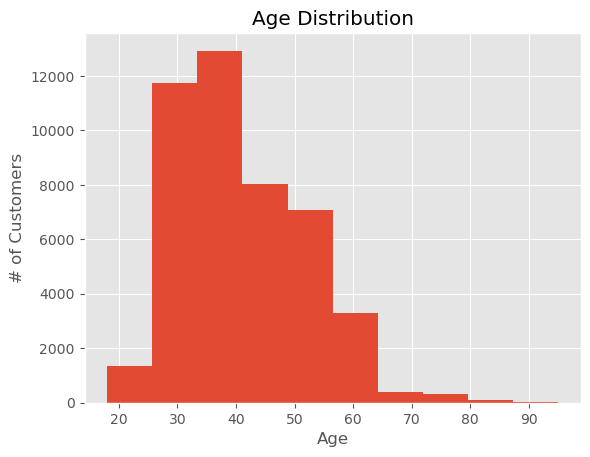

In [70]:
# distribution of customer age 

fig, ax =plt.subplots()

ax.hist(df['age'])
ax.set_xlabel('Age')
ax.set_ylabel('# of Customers')
ax.set_title('Age Distribution')

The distribution of age is right skewed with most clients being between ages 35 and 55. 

Text(0.5, 0.98, 'Default by Balance and Duration')

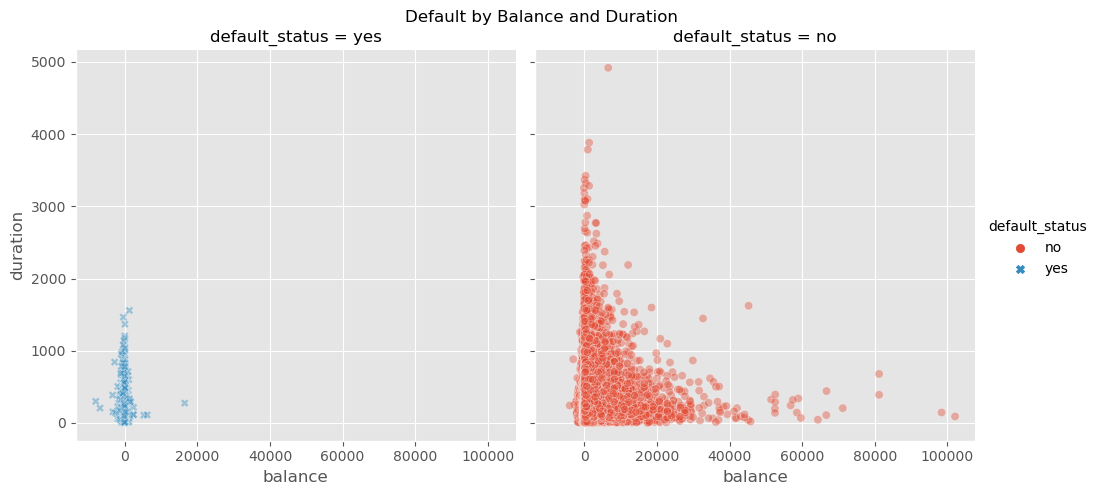

In [72]:
# default status by campaign duration and balance 

rp = sns.relplot(x='balance', y='duration', data=df, kind='scatter', col='default_status', 
            col_order=['yes','no'], style='default_status',hue='default_status',alpha=0.4)

rp.fig.subplots_adjust(top=0.9)
rp.fig.suptitle('Default by Balance and Duration')

There does not appear to be a linear relationship between balance and duration.

Text(0.5, 1.0, 'Default Status by Marital Status')

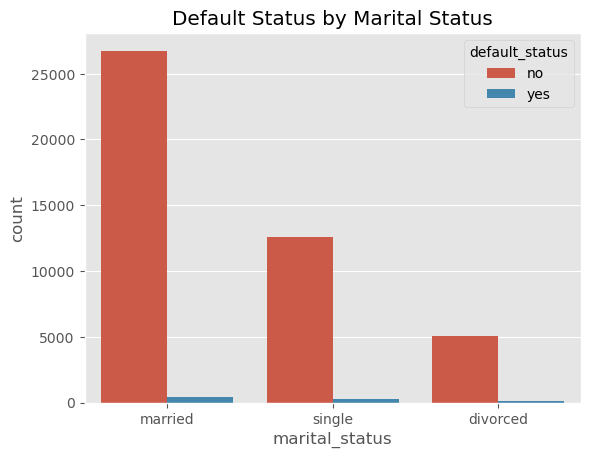

In [73]:
# default by marital status 

sns.countplot(x=df['marital_status'], hue='default_status', data=df).set_title('Default Status by Marital Status')

Default status does to appear to be related to marital status. However, as most clients surveyed after this campaign are married these results are likely biased. 

In [74]:
# select a target market list for new campaign 

# there is extra space after the current term description outcome 
df['subscribed'] = df['subscribed'].str.strip()

# balances over 25,000 and term deposit subscription is no 
target = df[(df['balance']>25000) & (df['subscribed']=='no')]
target[['age','default_status','balance','loan','duration','pdays','poutcome']].sort_values('pdays', ascending=False).head(10)


,age,default_status,balance,loan,duration,pdays,poutcome
44861,55,no,26306,no,84,589,failure
41798,46,no,37378,no,146,518,failure
35315,53,no,34230,yes,279,358,other
42379,46,no,31630,no,448,214,failure
25783,59,no,32948,no,243,174,failure
34424,34,no,26575,no,245,168,failure
31038,54,no,26306,no,27,84,failure
43953,71,no,29941,no,80,71,other
27327,58,no,26254,no,53,31,failure
29512,59,no,44134,no,117,-1,unknown


We create a list of potential clients to target for future campaigns. We consider clients with a large balance (greater than $25,000) and those who did not subscribe to a term deposit. The list is ordered by those with the longest time between campaigns. This would allow marketing to reach out to clients with the longest contact gap. 